# Asset Allocation Model

This is a general asset allocation stategy that invests a specified percent in each investment option and rebalances every month.  It was inspired by the book quote below.

pg. 161 from "Trading Evolved" by Andreas F. Clenow

"The rules of this first ETF model are the following.  We will use five ETFs to allocate our assets to.  Each ETF will have a target weight, and at the beginning of each month we will reset the allocation to this target weight."

25%  SPY - S&P500 Index Tracker ETF
30%  TLT - 20 Year Treasury ETF
30%  IEF - 7-10 Year Treasury ETF
7.5% GLD - Gold Tracker ETF
7.5% DBC - General Commodity Tracker ETF

Many other example portfolios are included, and it's easy to add more.

In [1]:
import datetime

import matplotlib.pyplot as plt
import pandas as pd
from talib.abstract import *

import pinkfish as pf

# Format price data.
pd.options.display.float_format = '{:0.2f}'.format

%matplotlib inline

In [2]:
# Set size of inline plots.
'''note: rcParams can't be in same cell as import matplotlib
   or %matplotlib inline
   
   %matplotlib notebook: will lead to interactive plots embedded within
   the notebook, you can zoom and resize the figure
   
   %matplotlib inline: only draw static images in the notebook
'''
plt.rcParams["figure.figsize"] = (10, 7)

Define Portfolios

In [3]:
# Large diversified ETFs
large_diversified_portfolio = {
    
    # stocks:US
    'SPY': 0.20, #1993
    'QQQ': 0.10, #1999
    # stocks:global ex-us and ex-canada
    'EFA': 0.05, #2001
    # stocks:emerging markets
    'EEM': 0.05, #2003
    #################### 40% total stocks
    
    # bonds:treasuries
    'TLT': 0.05, #2002
    'IEF': 0.05, #2002
    'TIP': 0.05, #2003
    'BSV': 0.05, #2007
    # bonds:corporate bonds
    'LQD': 0.05, #2002
    # bonds: fixed income
    'AGG': 0.05, #2003
    #################### 30% total bonds
    
    # metals
    'GLD': 0.10, #2004
    'SLV': 0.05, #2006
    #################### 15% total metals
    
    # commodities
    'DBC': 0.05, #2006
    ####################  5% total commodities
    
    # real estate
    'NLY': 0.10  #1997
    #################### 10% total real estate
}

# pinkfish portfolio
pinkfish_portfolio = \
    {'SPY': 0.20, 'QQQ':0.20, 'TLT': 0.20, 'NLY': 0.20, 'GLD': 0.20}

# 50% S&P 500, 50% treasury
fifty_fifty_portfolio = \
    {'SPY': 0.50, 'TLT': .50}

# 33% S&P 500, 33% treasury, 33% fixed income
thirds_portfolio = \
    {'SPY': 1/3, 'TLT': 1/3, 'AGG': 1/3}

# ETF portfolio in "Trading Evolved"
trading_evolved_portfolio = \
    {'SPY': 0.25, 'TLT': 0.30, 'IEF': 0.30, 'GLD': 0.075, 'DBC': 0.075}

# Dave Ramsey - 25% Growth and income, 25% Growth, 25% Aggressive growth, 25% International
dave_ramsey_portfolio = \
    {'SPY': 0.25, 'VQNPX': 0.25, 'RPG': 0.25, 'EFA': 0.25}

# Warren Buffett Retirement Fund: 90% S&P500, 10% Short Term Treasuries
warren_buffett_portfolio = \
    {'SPY': 0.90, 'SHY': 0.10}

# https://www.forbes.com/sites/baldwin/2016/07/25/eight-famous-portfolios/#42c50d7d5cce
# american households: 25% real estate, 30% stocks, 30% fixed income, 5% cash, 10% alternatives
american_households_portfolio = \
    {'NLY': 0.25, 'SPY': 0.30, 'AGG': 0.30, 'GLD': 0.10}

# Janet Yellen: 50% fixed income, 40% S&P500, 10% cash
janet_yellen_portfolio = \
    {'AGG': 0.50, 'SPY': 0.40}

# Janet Yellen: 50% fixed income, 40% S&P500, 10% gold
janet_yellen_plus_portfolio = \
    {'AGG': 0.50, 'SPY': 0.40, 'GLD': 0.10}

Some global data

In [4]:
# Select one of the above portfolios
portfolio_option = trading_evolved_portfolio

symbols = list(portfolio_option.keys())
capital = 10000
start = datetime.datetime(1900, 1, 1)
end = datetime.datetime.now()

In [5]:
options = {
    'use_adj' : True,
    'use_cache' : True,
    'margin' : 2.0,
}
options

{'use_adj': True, 'use_cache': True, 'margin': 2.0}

In [6]:
# Fetch timeseries
portfolio = pf.Portfolio()
ts = portfolio.fetch_timeseries(symbols, start, end, fields=['close'],
                                use_cache=options['use_cache'], use_adj=options['use_adj'])
# Add calendar columns
ts = portfolio.calendar(ts)

# Finalize timeseries
ts, start = portfolio.finalize_timeseries(ts, start)

# Init trade logs
portfolio.init_trade_logs(ts, capital, options['margin'])

In [7]:
pf.TradeLog.cash = capital
pf.TradeLog.margin = options['margin']

# Trading algorithm
for i, row in enumerate(ts.itertuples()):

    date = row.Index.to_pydatetime()
    end_flag = pf.is_last_row(ts, i)
    
    # Rebalance on the first trading day of each month
    if row.first_dotm or end_flag:

        #portfolio.print_holdings(date, row)
        
        # If last row, then zero out all weights.  Otherwise use portfolio_option weights.
        weights = portfolio_option if not end_flag else pf.set_dict_values(portfolio_option, 0)

        # Get closing prices for all symbols
        p = portfolio.get_prices(row, fields=['close'])
        prices = {symbol:p[symbol]['close'] for symbol in portfolio.symbols}
        
        # Adjust weights of all symbols in portfolio
        portfolio.adjust_percents(date, prices, weights, row)

    # Record daily balance.
    portfolio.record_daily_balance(date, row)

In [8]:
# Get logs
rlog, tlog, dbal = portfolio.get_logs()

In [9]:
rlog.head(10)

,date,seq_num,price,shares,entry_exit,direction,symbol
0,2006-03-01,0,95.36,52,entry,LONG,SPY
1,2006-03-01,1,56.41,106,entry,LONG,TLT
2,2006-03-01,2,56.12,106,entry,LONG,IEF
3,2006-03-01,3,56.10,26,entry,LONG,GLD
4,2006-03-01,4,21.17,70,entry,LONG,DBC
5,2006-04-03,5,96.00,1,exit,LONG,SPY
6,2006-04-03,6,54.17,1,entry,LONG,TLT
7,2006-04-03,7,58.47,1,exit,LONG,GLD
8,2006-04-03,8,21.91,3,exit,LONG,DBC
9,2006-05-01,9,52.27,4,entry,LONG,TLT


In [10]:
tlog.tail()

,entry_date,entry_price,exit_date,exit_price,pl_points,pl_cash,qty,cumul_total,direction,symbol
699,2021-01-04,119.75,2021-04-01,113.36,-6.39,-44.76,7,67501.07,LONG,IEF
700,2021-02-01,151.61,2021-04-01,137.51,-14.10,-112.80,8,67388.27,LONG,TLT
701,2021-02-01,118.56,2021-04-01,113.36,-5.20,-10.41,2,67377.86,LONG,IEF
702,2021-03-01,140.87,2021-04-01,137.51,-3.36,-23.50,7,67354.36,LONG,TLT
703,2021-03-01,161.53,2021-04-01,161.98,0.45,1.80,4,67356.16,LONG,GLD


In [11]:
dbal.tail()

,high,low,close,shares,cash,leverage,state
date,,,,,,,
2021-03-26,85841.64,85841.64,85841.64,1798,-85789.23,2.00,-
2021-03-29,85083.17,85083.17,85083.17,1798,-85789.23,2.01,-
2021-03-30,84749.61,84749.61,84749.61,1798,-85789.23,2.01,-
2021-03-31,84839.17,84839.17,84839.17,1798,-85789.23,2.01,-
2021-04-01,77356.16,77356.16,77356.16,0,77356.16,1.00,X


In [12]:
stats = pf.stats(ts, tlog, dbal, capital)
pf.print_full(stats)

start                                                   2006-02-06
end                                                     2021-04-01
beginning_balance                                            10000
ending_balance                                            77356.16
total_net_profit                                          67356.16
gross_profit                                              75479.84
gross_loss                                                -8123.68
profit_factor                                                 9.29
return_on_initial_capital                                   673.56
annual_return_rate                                           14.46
trading_period                           15 years 1 months 26 days
pct_time_in_market                                           99.58
margin                                                        2.00
avg_leverage                                                  1.98
max_leverage                                                  

,cumul_total,weight,pct_cumul_total,relative_performance
SPY,"$35,956.81",0.25,0.53,2.14
TLT,"$15,347.38",0.30,0.23,0.76
IEF,"$10,579.03",0.30,0.16,0.52
GLD,"$4,458.09",0.07,0.07,0.88
DBC,"$1,014.84",0.07,0.02,0.20
TOTAL,"$67,356.16",1.00,1.00,1.00


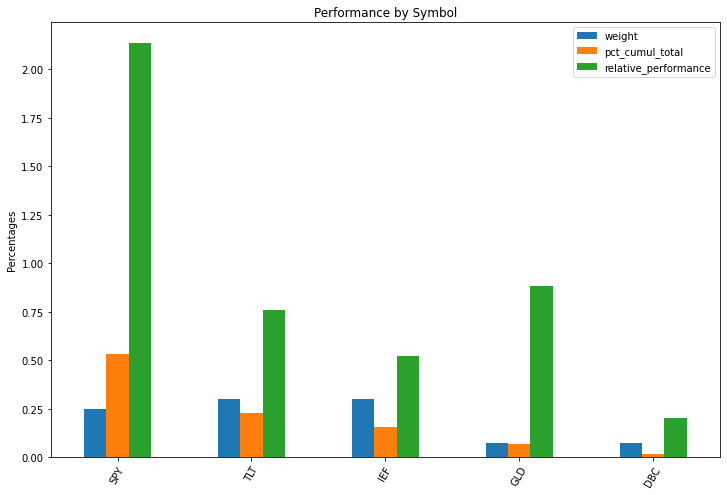

In [13]:
totals = portfolio.performance_per_symbol(portfolio_option)
totals

,SPY,TLT,IEF,GLD,DBC
SPY,1.00,-0.43,-0.42,0.04,0.45
TLT,-0.43,1.00,0.91,0.14,-0.26
IEF,-0.42,0.91,1.00,0.18,-0.24
GLD,0.04,0.14,0.18,1.00,0.38
DBC,0.45,-0.26,-0.24,0.38,1.00


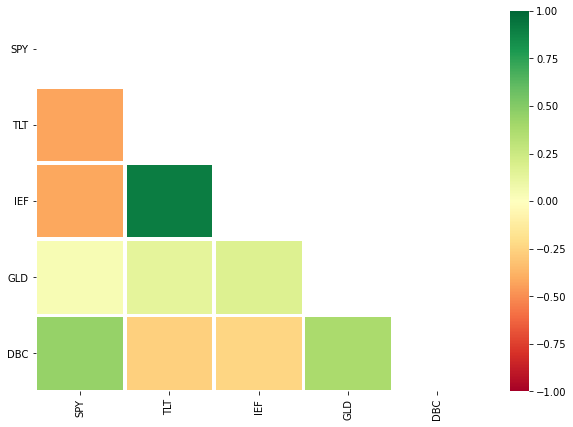

In [14]:
corr_df = portfolio.correlation_map(ts)
corr_df

In [15]:
benchmark = pf.Benchmark('SPY', capital, start, end, use_adj=True)
benchmark.run()

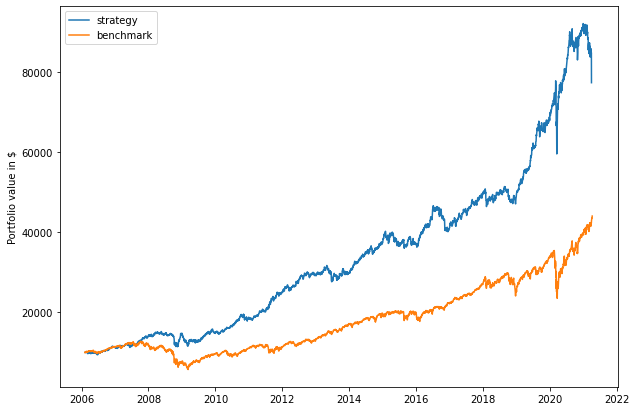

In [16]:
pf.plot_equity_curve(dbal, benchmark=benchmark.dbal)

In [17]:
df = pf.summary(stats, benchmark.stats, metrics=pf.currency_metrics)
df

,strategy,benchmark
beginning_balance,"$10,000.00","$10,000.00"
ending_balance,"$77,356.16","$44,044.54"
total_net_profit,"$67,356.16","$34,044.54"
gross_profit,"$75,479.84","$34,044.54"
gross_loss,"-$8,123.68",$0.00


,strategy,benchmark
annual_return_rate,14.46,10.27
max_closed_out_drawdown,-24.90,-55.12
annualized_return_over_max_drawdown,0.58,0.19
best_month,28.90,23.56
worst_month,-19.70,-30.97
sharpe_ratio,1.06,0.59
sortino_ratio,1.39,0.70
monthly_std,3.69,4.68
annual_std,13.13,16.39


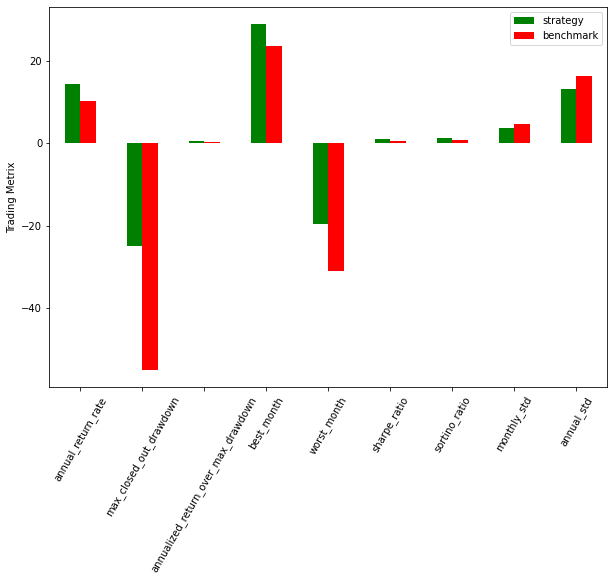

In [18]:
df = pf.plot_bar_graph(stats, benchmark.stats)
df

In [19]:
pf.kelly_criterian(stats, benchmark.stats)

sharpe_ratio            1.06
sharpe_ratio_max        1.12
sharpe_ratio_min        1.00
strategy risk           0.13
instrument risk         0.16
optimal target risk     1.06
half kelly criterian    0.53
aggressive leverage     6.46
moderate leverage       3.23
conservative leverage   3.04
dtype: float64